In [525]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Edge Permutation Test with Preserve Region

In [513]:
adj_mat = pd.read_csv(ConnFil, index_col=0)
g = LoadConnectome2(adj_mat) # Load Connectiome
EdgeWeightsDict = EdgeDict(g, keyon="label")
str2reg = STR2Region()
str2reg_df = pd.read_csv(MajorBrainDivisions, delimiter="\t")

In [514]:
reg2str = {}
for k,v in str2reg.items():
    if v not in reg2str:
        reg2str[v] = [k]
    else:
        reg2str[v].append(k)

### Restart

In [692]:
#Sib_Bias_avgz = pd.read_csv("dat/bias2/ASD.Siblings.spec.bias.csv", index_col="STR")
Sib_Bias_avgz = pd.read_csv("dat/Jon_data/sibling-exp_rank.csv")
Sib_Bias_avgz.columns = ["STR", "EFFECT", "Rank", "NGene"]
Sib_Bias_avgz = Sib_Bias_avgz.set_index("STR")

In [693]:
Sib_Bias_avgz.head(2)

,EFFECT,Rank,NGene
STR,,,
Posterior_limiting_nucleus_of_the_thalamus,0.137984,1,1234
Anterior_pretectal_nucleus,0.135440,2,1234


In [694]:
Reg2Reg = CountReg2RegConn(adj_mat, str2reg)
WithinRegion, CrossRegion_SRC, CrossRegion_TGT, CrossRegion_W = SortConnByRegion(Reg2Reg)

In [695]:
adj_mat_perm = EdgePermutation_V1(adj_mat, WithinRegion, CrossRegion_SRC, CrossRegion_TGT, CrossRegion_W, str2reg)

In [696]:
ASD_Conn_perm, ASD_Cohe_perm = [], []
Sib_Conn_perm, Sib_Cohe_perm = [], []
for i in range(1000):
    adj_mat_ = pd.read_csv("dat/permut_connectome/{}.csv".format(i), index_col=0)
    g_ = LoadConnectome2(adj_mat_)
    x,y = ScoreSTRSet(g_, SparkMetaBias.head(100).index.values, EdgeWeightsDict)
    ASD_Conn_perm.append(y)
    ASD_Cohe_perm.append(x)
    x,y = ScoreSTRSet(g_, Sib_Bias_avgz.head(100).index.values, EdgeWeightsDict)
    Sib_Conn_perm.append(y)
    Sib_Cohe_perm.append(x)
ASD_Cohe, ASD_Conn = ScoreSTRSet(g, SparkMetaBias.head(100).index.values, EdgeWeightsDict)
Sib_Cohe, Sib_Conn = ScoreSTRSet(g, Sib_Bias_avgz.head(100).index.values, EdgeWeightsDict)

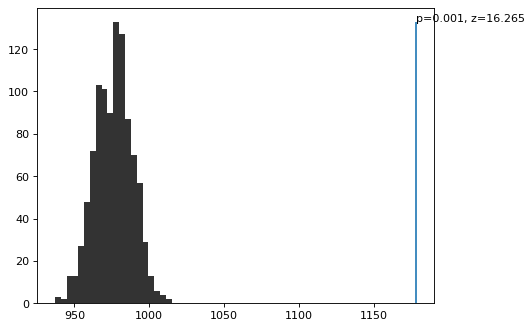

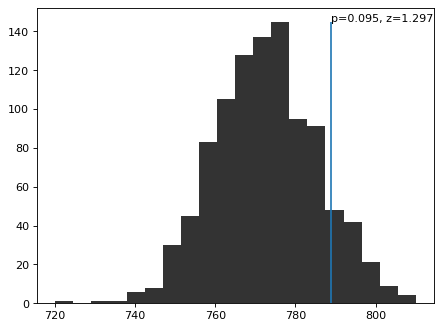

In [697]:
PlotPermutationP(ASD_Conn_perm, ASD_Conn)
PlotPermutationP(Sib_Conn_perm, Sib_Conn)

In [698]:
topNs = list(range(200, 10, -5))
ASD_Conn_Z, ASD_Cohe_Z, ASD_Conn_P, ASD_Cohe_P, ASD_Conn_E, ASD_Cohe_E = [],[],[],[],[],[]
Sib_Conn_Z, Sib_Cohe_Z, Sib_Conn_P, Sib_Cohe_P, Sib_Conn_E, Sib_Cohe_E = [],[],[],[],[],[]
for topN in topNs:
    Permuted_ASD_cohe = []
    Permuted_ASD_conn = []
    Permuted_Sib_cohe = []
    Permuted_Sib_conn = []
    for i in range(10000):
        adj_mat_perm = pd.read_csv("dat/permut_connectome/{}.csv".format(i), index_col=0)
        g_perm = LoadConnectome2(adj_mat_perm)
        asd_cohe, asd_conn = ScoreSTRSet(g_perm, SparkMetaBias.head(topN).index.values, EdgeWeightsDict)
        sib_cohe, sib_conn = ScoreSTRSet(g_perm, Sib_Bias_avgz.head(topN).index.values, EdgeWeightsDict)
        Permuted_ASD_cohe.append(asd_cohe)
        Permuted_ASD_conn.append(asd_conn)
        Permuted_Sib_cohe.append(sib_cohe)
        Permuted_Sib_conn.append(sib_conn)
    asd_cohe, asd_conn = ScoreSTRSet(g, SparkMetaBias.head(topN).index.values, EdgeWeightsDict)
    sib_cohe, sib_conn = ScoreSTRSet(g, Sib_Bias_avgz.head(topN).index.values, EdgeWeightsDict)
    
    asd_z_conn, asd_p_conn = GetPermutationP(Permuted_ASD_conn, asd_conn)
    asd_z_cohe, asd_p_cohe = GetPermutationP(Permuted_ASD_cohe, asd_cohe)
    effect_conn = asd_conn/np.mean(Permuted_ASD_conn)
    effect_cohe = asd_cohe/np.mean(Permuted_ASD_cohe)
    ASD_Conn_Z.append(asd_z_conn); ASD_Cohe_Z.append(asd_z_cohe)
    ASD_Conn_P.append(asd_p_conn); ASD_Cohe_P.append(asd_p_cohe)
    ASD_Conn_E.append(effect_conn); ASD_Cohe_E.append(effect_cohe)
    
    sib_z_conn, sib_p_conn = GetPermutationP(Permuted_Sib_conn, sib_conn)
    sib_z_cohe, sib_p_cohe = GetPermutationP(Permuted_Sib_cohe, sib_cohe)
    effect_conn = sib_conn/np.mean(Permuted_Sib_conn)
    effect_cohe = sib_cohe/np.mean(Permuted_Sib_cohe)
    Sib_Conn_Z.append(sib_z_conn); Sib_Cohe_Z.append(sib_z_cohe)
    Sib_Conn_P.append(sib_p_conn); Sib_Cohe_P.append(sib_p_cohe)
    Sib_Conn_E.append(effect_conn); Sib_Cohe_E.append(effect_cohe)

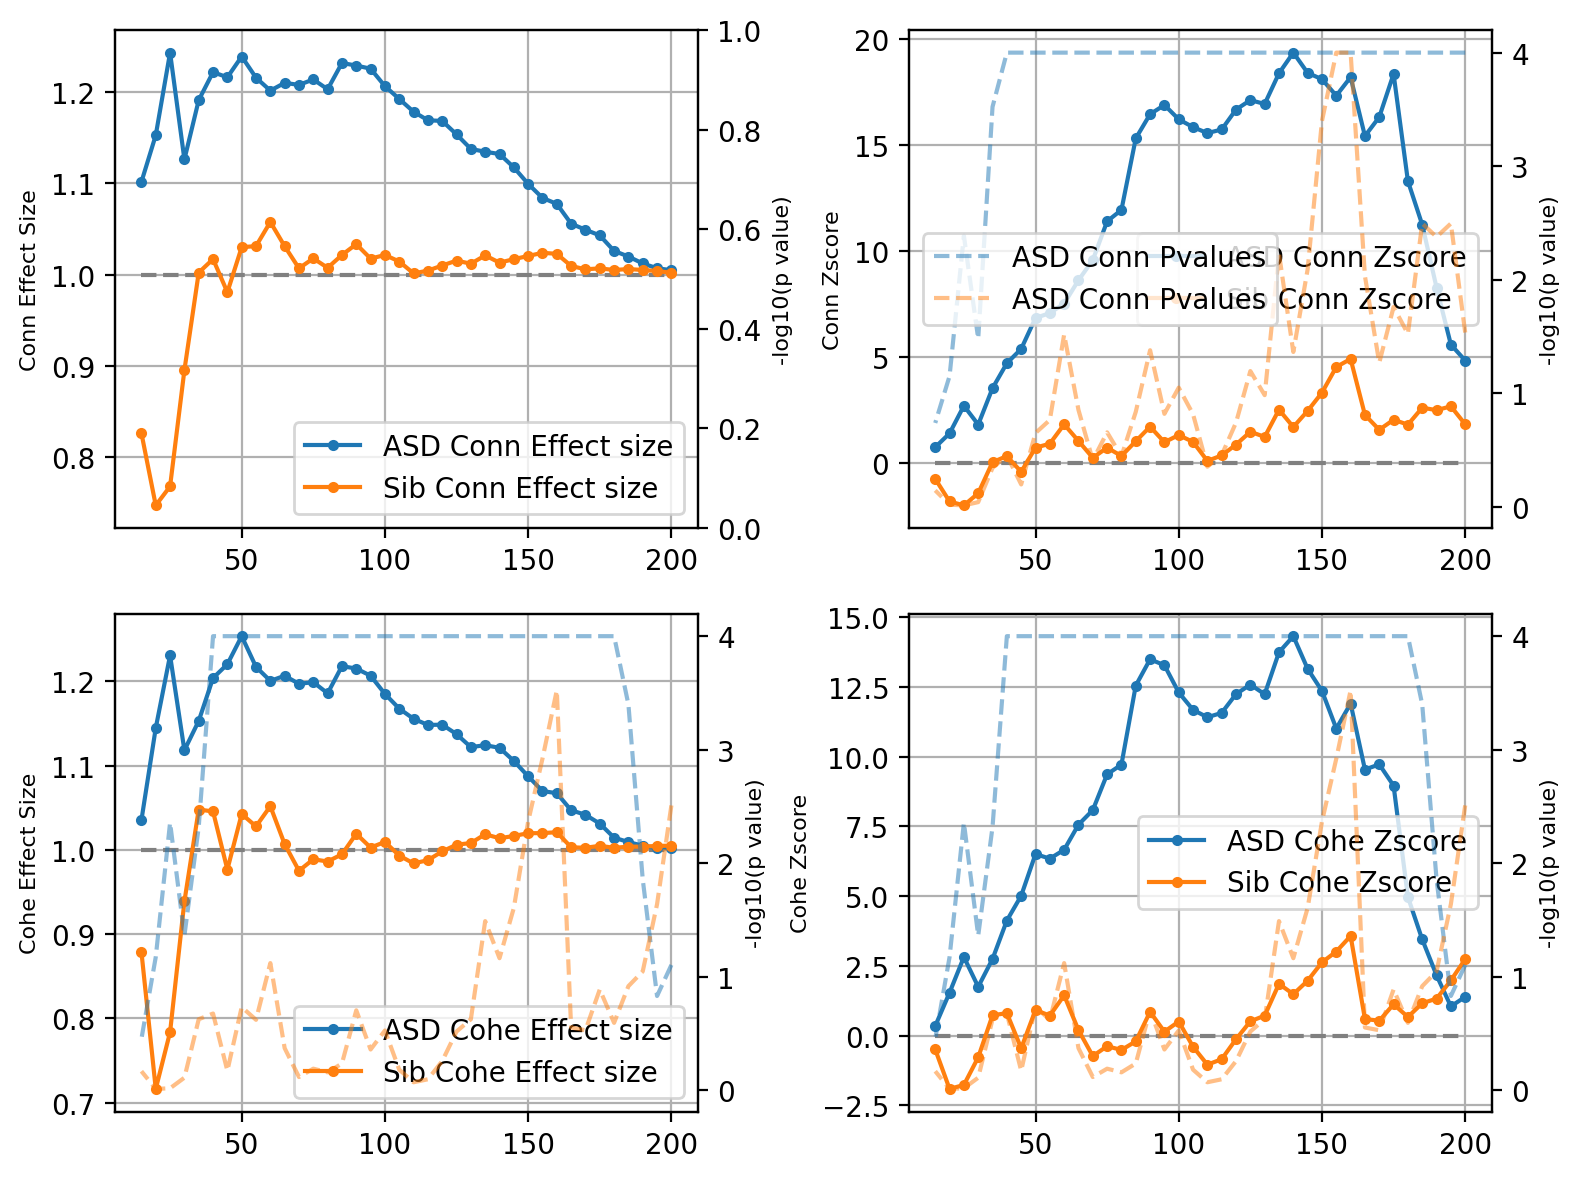

In [702]:
ASD_Conn_P = np.array(ASD_Conn_P)
fig, axs = plt.subplots(2,2, dpi=200, figsize=(8,6))
axs[0,0].plot(topNs, ASD_Conn_E, label="ASD Conn Effect size", marker=".")
axs[0,0].plot(topNs, Sib_Conn_E, label="Sib Conn Effect size", marker=".")
axs[0,0].hlines(xmin=min(topNs), xmax=max(topNs), y=1, ls="--", color="grey")
axs[0,0].grid(True)
axs[0,0].legend(loc=0)
axs[0,0].set_ylabel("Conn Effect Size",fontsize=8)
ax2=axs[0,0].twinx()
#ax2.plot(topNs, -np.log10(ASD_Conn_P), label="ASD Conn Pvalues", alpha=0.5, ls="--")
#ax2.plot(topNs, -np.log10(Sib_Conn_P), label="ASD Conn Pvalues", alpha=0.5, ls="--")
ax2.set_ylabel("-log10(p value)",fontsize=8)
#ax2.legend(loc=0)

axs[0,1].plot(topNs, ASD_Conn_Z, label="ASD Conn Zscore", marker=".")
axs[0,1].plot(topNs, Sib_Conn_Z, label="Sib Conn Zscore", marker=".")
axs[0,1].hlines(xmin=min(topNs), xmax=max(topNs), y=0, ls="--", color="grey")
axs[0,1].grid(True)
axs[0,1].legend(loc=0)
axs[0,1].set_ylabel("Conn Zscore",fontsize=8)
ax2=axs[0,1].twinx()
ax2.plot(topNs, -np.log10(ASD_Conn_P), label="ASD Conn Pvalues", alpha=0.5, ls="--")
ax2.plot(topNs, -np.log10(Sib_Conn_P), label="ASD Conn Pvalues", alpha=0.5, ls="--")
ax2.set_ylabel("-log10(p value)",fontsize=8) 
ax2.legend(loc=0)

axs[1,0].plot(topNs, ASD_Cohe_E, label="ASD Cohe Effect size", marker=".")
axs[1,0].plot(topNs, Sib_Cohe_E, label="Sib Cohe Effect size", marker=".")
axs[1,0].hlines(xmin=min(topNs), xmax=max(topNs), y=1, ls="--", color="grey")
axs[1,0].grid(True)
axs[1,0].legend()
axs[1,0].set_ylabel("Cohe Effect Size",fontsize=8)
ax2=axs[1,0].twinx()
ax2.plot(topNs, -np.log10(ASD_Cohe_P), label="ASD Conn Pvalues", alpha=0.5, ls="--")
ax2.plot(topNs, -np.log10(Sib_Cohe_P), label="ASD Conn Pvalues", alpha=0.5, ls="--")
ax2.set_ylabel("-log10(p value)",fontsize=8)

axs[1,1].plot(topNs, ASD_Cohe_Z, label="ASD Cohe Zscore", marker=".")
axs[1,1].plot(topNs, Sib_Cohe_Z, label="Sib Cohe Zscore", marker=".")
axs[1,1].hlines(xmin=min(topNs), xmax=max(topNs), y=0, ls="--", color="grey")
axs[1,1].grid(True)
axs[1,1].legend()
axs[1,1].set_ylabel("Cohe Zscore",fontsize=8)
ax2=axs[1,1].twinx() 
ax2.plot(topNs, -np.log10(ASD_Cohe_P), label="ASD Conn Pvalues", alpha=0.5, ls="--")
ax2.plot(topNs, -np.log10(Sib_Cohe_P), label="ASD Conn Pvalues", alpha=0.5, ls="--")
ax2.set_ylabel("-log10(p value)",fontsize=8)

plt.tight_layout()
plt.savefig("figs/Edge_Permutation.ASD.Sib.topN.pdf")

In [677]:
-np.log10(0.05/200)

3.6020599913279625

In [676]:
0.00025 * 10000

2.5

In [579]:
g_perm = LoadConnectome2(adj_mat_perm)

4118.0


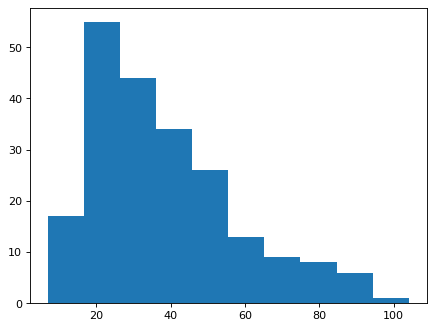

4118.0


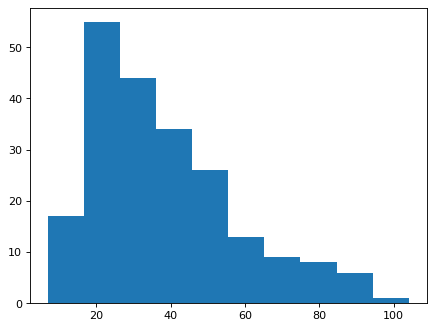

In [580]:
dg = g_perm.degree()
plt.hist(dg)
print(sum(dg)/2)
plt.show()
dg = g.degree()
plt.hist(dg)
print(sum(dg)/2)

In [519]:
WithinRegion = {}
CrossRegion_SRC, CrossRegion_TGT, CrossRegion_W = [], [], []
for reg2reg, obj in Reg2Reg.items():
    reg1, reg2 = reg2reg.split("-")
    if reg1 == reg2:
        Sources, Targets, Weights = [], [],[]
        for src, tgt, w in obj:
            Sources.append(src)
            Targets.append(tgt)
            Weights.append(w)
        WithinRegion[reg2reg] = (Sources, Targets, Weights)
    else:
        for src, tgt, w in obj:
            CrossRegion_SRC.append(src)
            CrossRegion_TGT.append(tgt)
            CrossRegion_W.append(w)

In [522]:
#test_cross_region
CrossRegion_SRC = [item for items, c in Counter(CrossRegion_SRC).most_common()
                                      for item in [items] * c]

In [524]:
adj_mat_permut = pd.DataFrame(data=np.zeros((213,213)), index=adj_mat.index.values,
                  columns=adj_mat.columns.values)             
    for i, w in enumerate(CrossRegion_W):
        src = CrossRegion_SRC[0]
        N_stuck = 0
        while 1:
            tgt = np.random.choice(CrossRegion_TGT)
            if adj_mat_permut.loc[src, tgt] == 0 and str2reg[src]!=str2reg[tgt]:
                adj_mat_permut.loc[src, tgt] = w
                N_stuck = 0
                CrossRegion_SRC.pop(0)
                CrossRegion_TGT.remove(tgt)
                break
            else:
                N_stuck += 1
            #print(i, src, tgt, N_stuck)    

### Old

In [230]:
# adj_mat
# Count Region2Region Connections
def CountReg2RegConn(adj_mat):
    Reg2Reg_weights = {}
    Reg2Reg_Nodes = {}
    ConnectionDictionary_Source_Key = {}
    ConnectionDictionary_Target_Key = {}
    for STR_i in adj_mat.index.values:
        for STR_j in adj_mat.columns.values:
            conn_w = adj_mat.loc[STR_i, STR_j]
            if conn_w != 0:
                if STR_i not in ConnectionDictionary_Source_Key:
                    ConnectionDictionary_Source_Key[STR_i] = [STR_j]
                else:
                    ConnectionDictionary_Source_Key[STR_i].append(STR_j)
                if STR_j not in ConnectionDictionary_Target_Key:
                    ConnectionDictionary_Target_Key[STR_j] = [STR_i]
                else:
                    ConnectionDictionary_Target_Key[STR_j].append(STR_i)
                Reg1 = str2reg[STR_i]
                Reg2 = str2reg[STR_j]
                if "{}-{}".format(Reg1, Reg2) not in Reg2Reg_weights:
                    Reg2Reg_weights["{}-{}".format(Reg1, Reg2)] = [conn_w]
                    Reg2Reg_Nodes["{}-{}".format(Reg1, Reg2)] = ([STR_i],[STR_j])
                else:
                    Reg2Reg_weights["{}-{}".format(Reg1, Reg2)].append(conn_w)
                    Reg2Reg_Nodes["{}-{}".format(Reg1, Reg2)][0].append(STR_i)
                    Reg2Reg_Nodes["{}-{}".format(Reg1, Reg2)][1].append(STR_j)
    return Reg2Reg_weights, Reg2Reg_Nodes, ConnectionDictionary_Source_Key, ConnectionDictionary_Target_Key

def CountReg2RegConn2(adj_mat):
    Reg2Reg = {}
    for STR_i in adj_mat.index.values:
        for STR_j in adj_mat.columns.values:
            conn_w = adj_mat.loc[STR_i, STR_j]
            if conn_w != 0:
                Reg1 = str2reg[STR_i]
                Reg2 = str2reg[STR_j]
                connR = "{}-{}".format(Reg1, Reg2)
                #connS = "{}-{}-{}".format(STR_i, STR_j, conn_w)
                connS = (STR_i, STR_j, conn_w)
                if connR not in Reg2Reg:
                    Reg2Reg[connR] = [connS]
                else:
                    Reg2Reg[connR].append(connS)
    return Reg2Reg

def CountReg2RegConn3(adj_mat):
    Reg2Reg = {}
    for STR_i in adj_mat.index.values:
        for STR_j in adj_mat.columns.values:
            conn_w = adj_mat.loc[STR_i, STR_j]
            if conn_w != 0:
                Reg1 = str2reg[STR_i]
                Reg2 = str2reg[STR_j]
                connR = "{}-{}".format(Reg1, Reg2)
                #connS = "{}-{}-{}".format(STR_i, STR_j, conn_w)
                connS = (STR_i, STR_j, conn_w)
                if connR not in Reg2Reg:
                    Reg2Reg[connR] = [connS]
                else:
                    Reg2Reg[connR].append(connS)
    return Reg2Reg

In [551]:
#Reg2Reg_weights, Reg2Reg_Nodes, Conn_Source, Conn_Target = CountReg2RegConn(adj_mat)
Reg2Reg = CountReg2RegConn2(adj_mat)

In [552]:
#random.shuffle(Reg2Reg['Pons-Thalamus'])
#Reg2Reg['Pons-Thalamus']

In [553]:
## Test Region2Region within
obj = Reg2Reg['Striatum-Striatum']
Sources, Targets, Weights = [], [],[]
for src, tgt, w in obj:
    Sources.append(src)
    Targets.append(tgt)
    Weights.append(w)
print(len(Weights))

7


In [554]:
Sources

['Nucleus_accumbens',
 'Central_amygdalar_nucleus',
 'Intercalated_amygdalar_nucleus',
 'Intercalated_amygdalar_nucleus',
 'Medial_amygdalar_nucleus',
 'Medial_amygdalar_nucleus',
 'Olfactory_tubercle']

In [555]:
Targets

['Lateral_septal_nucleus_ventral_part',
 'Caudoputamen',
 'Fundus_of_striatum',
 'Olfactory_tubercle',
 'Lateral_septal_nucleus_ventral_part',
 'Olfactory_tubercle',
 'Anterior_amygdalar_area']

In [556]:
Sources_sorted = [item for items, c in Counter(Sources).most_common()
                                      for item in [items] * c]

In [557]:
adj_mat_permut = pd.DataFrame(data=np.zeros((213,213)), index=adj_mat.index.values,
                  columns=adj_mat.columns.values)             
for i, w in enumerate(Weights):
    src = Sources_sorted[0]
    N_stuck = 0
    while 1:
        tgt = np.random.choice(Targets)
        if adj_mat_permut.loc[src, tgt] == 0 and src!=tgt:
            adj_mat_permut.loc[src, tgt] = w
            N_stuck = 0
            Sources_sorted.pop(0)
            Targets.remove(tgt)
            break
        else:
            N_stuck += 1
            print(i, src, tgt, N_stuck)    

In [541]:
a = [1,1,1,2,2,3,4,5,6,7,8,9]
ele = np.random.choice(a)
print(ele)
a.remove(ele)
a

7


[1, 1, 1, 2, 2, 3, 4, 5, 6, 8, 9]

In [313]:
def CheckPair(XXX1, XXX2):
    SET = set([])
    for X1, X2 in zip(XXX1, XXX2):
        Conn = "{}-{}".format(X1, X2)
        if Conn in SET:
            return False
        else:
            SET.add("{}-{}".format(X1, X2))
    return True
def EdgePermutation(adj_mat, Reg2Reg_weights, Reg2Reg_Nodes, reg2str):
    adj_mat_permut = pd.DataFrame(data=np.zeros((213,213)), index=adj_mat.index.values, 
                                  columns=adj_mat.columns.values)
    cp_Reg2Reg_weights = copy.deepcopy(Reg2Reg_weights)
    cp_Reg2Reg_Nodes = copy.deepcopy(Reg2Reg_Nodes)
    for Reg2Reg in cp_Reg2Reg_weights.keys():
        while 1:
            print(Reg2Reg)
            random.shuffle(cp_Reg2Reg_weights[Reg2Reg])
            random.shuffle(cp_Reg2Reg_Nodes[Reg2Reg][0])
            random.shuffle(cp_Reg2Reg_Nodes[Reg2Reg][1])
            if CheckPair(cp_Reg2Reg_Nodes[Reg2Reg][0], cp_Reg2Reg_Nodes[Reg2Reg][1]):
                break
        SRC_Reg, TGT_Reg = Reg2Reg.split("-")
        while len(cp_Reg2Reg_weights[Reg2Reg]) != 0:
            #print(Reg2Reg, len(cp_Reg2Reg_weights[Reg2Reg]))
            w_conn = cp_Reg2Reg_weights[Reg2Reg].pop()
            SRC_STR = cp_Reg2Reg_Nodes[Reg2Reg][0].pop()
            TGT_STR = cp_Reg2Reg_Nodes[Reg2Reg][1].pop()
            adj_mat_permut.loc[SRC_STR, TGT_STR] = w_conn
    return adj_mat_permut

def EdgeSwapping(adj_mat, Reg2Reg):
    adj_mat_permut = pd.DataFrame(data=np.zeros((213,213)), index=adj_mat.index.values, 
                                  columns=adj_mat.columns.values)
    Total_Conn = 0
    ConnSet = set([])
    for reg2reg, edgelist in Reg2Reg.items():
        random.shuffle(edgelist)
        N_stuck = 0
        while len(edgelist) > 1:
            if N_stuck > 10:
                print(reg2reg, N_stuck, len(edgelist))
                for i in range(len(edgelist)):
                    str_i_1, str_j_1, w_1 = edgelist[i]
                    adj_mat_permut.loc[str_i_1, str_j_2] = w_1
                break
            str_i_1, str_j_1, w_1 = edgelist[0]
            str_i_2, str_j_2, w_2 = edgelist[1]
            if (str_i_1 != str_j_2) and (str_i_2 != str_j_1) and  \
                    ("{}-{}".format(str_i_1, str_j_2) not in ConnSet) and ("{}-{}".format(str_i_2, str_j_1) not in ConnSet):
                adj_mat_permut.loc[str_i_1, str_j_2] = w_1
                adj_mat_permut.loc[str_i_2, str_j_1] = w_2
                ConnSet.add("{}-{}".format(str_i_1, str_j_2))
                ConnSet.add("{}-{}".format(str_i_2, str_j_1))
                N_stuck = 0
            else:
                N_stuck += 1
                random.shuffle(edgelist)
        
    print(Total_Conn, len(ConnSet))
    return adj_mat_permut

def EdgePermutation(adj_mat, ):
    adj_mat_permut = pd.DataFrame(data=np.zeros((213,213)), index=adj_mat.index.values, 
                                  columns=adj_mat.columns.values)
    for reg2reg in Reg2Reg.keys():
        SRC_Reg, TGT_Reg = reg2reg.split("-")
        In_probs, Out_probs, weights = Reg2Reg[reg2reg]
        while len(weights) > 0:
            str_i = np.random.choice(NodeList_i, p=In_probs)
            str_j = np.random.choice(NodeList_j, p=Out_probs)
            if "{}-{}".format(str_i, str_j) not in EdgeSet:
                adj_mat_permut.loc[SRC_STR, TGT_STR] = weights[-1]
                weights.pop()
    return adj_mat_permut

In [314]:
adj_mat_permut = EdgeSwapping(adj_mat, Reg2Reg)
g_permut = LoadConnectome2(adj_mat_permut)

Striatum-Olfactory_areas 11 13
Striatum-Midbrain 11 16
Striatum-Cortical_subplate 11 2
Striatum-Thalamus 11 9
Isocortex-Isocortex 11 342
Isocortex-Thalamus 11 299
Isocortex-Olfactory_areas 11 24
Isocortex-Midbrain 11 134
Isocortex-Cortical_subplate 11 34
Isocortex-Striatum 11 48
Isocortex-Pons 11 87
Isocortex-Hypothalamus 11 29
Isocortex-Hippocampal_formation 11 18
Striatum-Pallidum 11 12
Striatum-Hypothalamus 11 26
Striatum-Striatum 11 7
Thalamus-Isocortex 11 126
Thalamus-Hippocampal_formation 11 19
Hypothalamus-Hypothalamus 11 155
Hypothalamus-Midbrain 11 72
Hypothalamus-Striatum 11 36
Hypothalamus-Thalamus 11 104
Hypothalamus-Pallidum 11 30
Isocortex-Pallidum 11 27
Isocortex-Medulla 11 82
Medulla-Medulla 11 213
Medulla-Cerebellum 11 77
Thalamus-Striatum 11 39
Thalamus-Cerebellum 11 2
Thalamus-Thalamus 11 62
Cerebellum-Cerebellum 11 30
Cerebellum-Pons 11 17
Olfactory_areas-Olfactory_areas 11 49
Olfactory_areas-Striatum 11 37
Olfactory_areas-Thalamus 11 2
Olfactory_areas-Cortical_subp

In [283]:
#adj_mat_permut = EdgePermutation(adj_mat, Reg2Reg_weights, Reg2Reg_Nodes, reg2str)
#g_permut = LoadConnectome2(adj_mat_permut)

5065.0


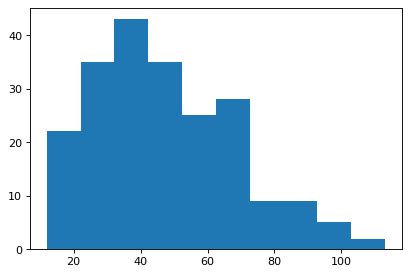

In [309]:
dg = g_permut.degree()
plt.hist(dg)
print(sum(dg)/2)

4118.0


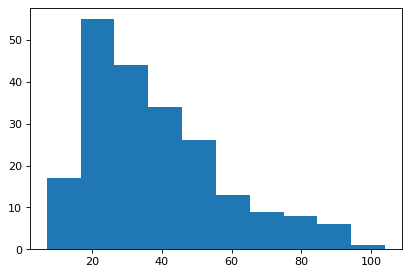

In [310]:
dg = g.degree()
plt.hist(dg)
print(sum(dg)/2)

In [48]:
for i in range(1000):
    adj_mat_permut = EdgePermutation(adj_mat, Reg2Reg, reg2str)
    adj_mat_permut.to_csv("dat/permut_connectome/{}.csv".format(i))

In [40]:
ASD_Bias_avgz = pd.read_csv("dat/bias2/ASD_LGD_Dmis_avgz.bias.csv", index_col="STR")
Sib_Bias_avgz = pd.read_csv("dat/bias2/ASD.Siblings.avgz.bias.csv", index_col="STR")

In [71]:
SparkMetaBias = pd.read_csv("dat/Jon_data/Spark_Final_ExpBias.csv")
SparkMetaBias.columns = ["STR", "EFFECT", "Rank", "NGene"]
SparkMetaBias = SparkMetaBias.set_index("STR")

In [104]:
def subgraph(g_complete, node_names):
    top_nodes = g_complete.vs.select(label_in=node_names)
    g_sub = g_complete.subgraph(top_nodes)
    return g_sub

In [130]:
Permuted_ASD_cohe = []
Permuted_ASD_conn = []
Permuted_ASD_short_path = []

topN = 40

for i in range(1000):
    adj_mat_ = pd.read_csv("dat/permut_connectome/{}.csv".format(i), index_col=0)
    g_ = LoadConnectome2(adj_mat_)
    #x,y = ScoreSTRSet(g_, SparkMetaBias.head(50).index.values, EdgeWeightsDict)
    #Permuted_ASD_cohe.append(x)
    #Permuted_ASD_conn.append(y)
    _subgraph = subgraph(g_, ASD_Bias_avgz.head(topN).index.values)
    avg_path = _subgraph.average_path_length(directed=False)
    Permuted_ASD_short_path.append(avg_path)
    
g_ = g.copy()
top_structs = ASD_Bias_avgz.head(topN).index.values
top_nodes = g_.vs.select(label_in=top_structs)
g_sub = g.subgraph(top_nodes)
ASD_AvgPath = g_sub.average_path_length(directed=False)

In [134]:
ASD_AvgPath

2.269230769230769

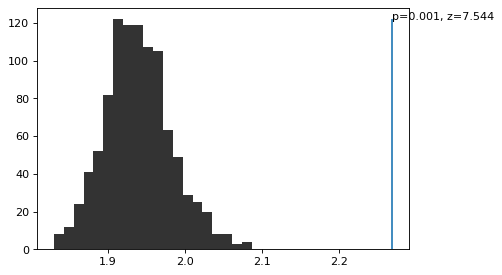

In [131]:
PlotPermutationP(Permuted_ASD_short_path, ASD_AvgPath)

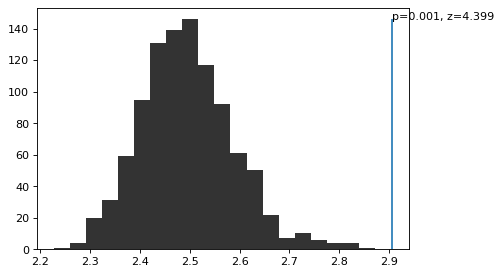

In [129]:
PlotPermutationP(Permuted_ASD_short_path, ASD_AvgPath)

In [125]:
help(g_sub.average_path_length)

Help on built-in function average_path_length:

average_path_length(...) method of igraph.Graph instance
    average_path_length(directed=True, unconn=True)
    
    Calculates the average path length in a graph.
    
    @param directed: whether to consider directed paths in case of a
      directed graph. Ignored for undirected graphs.
    @param unconn: what to do when the graph is unconnected. If C{True},
      the average of the geodesic lengths in the components is
      calculated. Otherwise for all unconnected vertex pairs,
      a path length equal to the number of vertices is used.
    @return: the average path length in the graph



In [75]:
XXX, YYY = ScoreSTRSet(g, SparkMetaBias.head(50).index.values, EdgeWeightsDict)

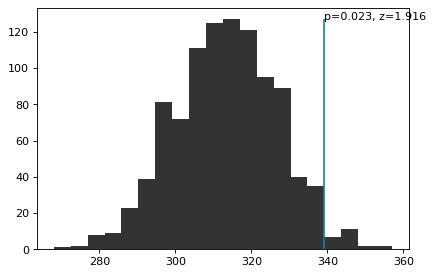

In [76]:
PlotPermutationP(Permuted_ASD_conn, YYY)

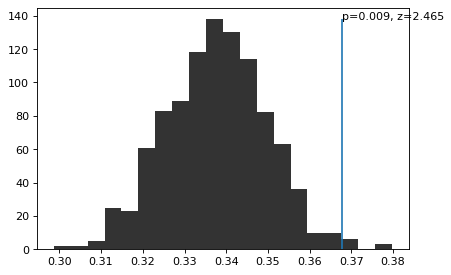

In [77]:
PlotPermutationP(Permuted_ASD_cohe, XXX)

In [132]:
0.36/0.34

1.0588235294117645

In [133]:
340/320

1.0625

In [91]:
Permuted_ASD_cohe2 = []
Permuted_ASD_conn2 = []
for i in range(1000):
    adj_mat_ = pd.read_csv("dat/permut_connectome/{}.csv".format(i), index_col=0)
    g_ = LoadConnectome2(adj_mat_)
    x,y = ScoreSTRSet(g_, ASD_Bias_avgz.head(30).index.values, EdgeWeightsDict)
    Permuted_ASD_cohe2.append(x)
    Permuted_ASD_conn2.append(y)
XXX2, YYY2 = ScoreSTRSet(g, ASD_Bias_avgz.head(30).index.values, EdgeWeightsDict)

In [95]:
for topN in range(100, 10, -10):
    Permuted_ASD_cohe2 = []
    Permuted_ASD_conn2 = []
    for i in range(1000):
        adj_mat_ = pd.read_csv("dat/permut_connectome/{}.csv".format(i), index_col=0)
        g_ = LoadConnectome2(adj_mat_)
        x,y = ScoreSTRSet(g_, ASD_Bias_avgz.head(topN).index.values, EdgeWeightsDict)
        Permuted_ASD_cohe2.append(x)
        Permuted_ASD_conn2.append(y)
    XXX2, YYY2 = ScoreSTRSet(g, ASD_Bias_avgz.head(topN).index.values, EdgeWeightsDict)
    Z, P = GetPermutationP(Permuted_ASD_cohe2, XXX2)
    Z2, P2 = GetPermutationP(Permuted_ASD_conn2, YYY2)
    print(topN, Z, P, Z2, P2)

100 3.250207097301457 0.0009990009990009652 0.7594303962047305 0.2187812187812188
90 3.111377753123418 0.0009990009990009652 1.5220157448246157 0.05294705294705293
80 3.575337031765557 0.0009990009990009652 2.6801027519209257 0.004995004995005048
70 3.36885566535564 0.0009990009990009652 2.653555891642153 0.0019980019980020414
60 3.402984199816487 0.0019980019980020414 2.8951955131319083 0.0019980019980020414
50 2.0417808719621764 0.017982017982017928 1.392064229563679 0.08091908091908095
40 -1.702174315921921 0.952047952047952 -2.333700627066514 0.988011988011988
30 0.5064853360167121 0.2957042957042957 1.1151297487624328 0.1208791208791209
20 -1.6429614842084228 0.945054945054945 -1.9040447426342764 0.965034965034965


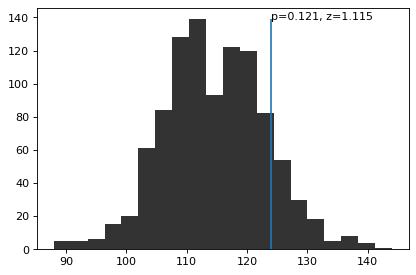

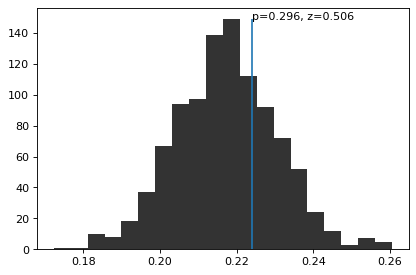

In [92]:
PlotPermutationP(Permuted_ASD_conn2, YYY2)
PlotPermutationP(Permuted_ASD_cohe2, XXX2)

In [116]:
Permuted_Sib_cohe = []
Permuted_Sib_conn = []
Permuted_Sib_short_path = []
for i in range(1000):
    adj_mat_ = pd.read_csv("dat/permut_connectome/{}.csv".format(i), index_col=0)
    g_ = LoadConnectome2(adj_mat_)
    x,y = ScoreSTRSet(g_, Sib_Bias_avgz.head(50).index.values, EdgeWeightsDict)
    Permuted_Sib_cohe.append(x)
    Permuted_Sib_conn.append(y)
    _subgraph = subgraph(g_, Sib_Bias_avgz.head(50).index.values)
    avg_path = _subgraph.average_path_length()
    Permuted_Sib_short_path.append(avg_path)
Sib_Cohe, Sib_Conn = ScoreSTRSet(g, Sib_Bias_avgz.head(50).index.values, EdgeWeightsDict)
Sib_Short = subgraph(g, Sib_Bias_avgz.head(50).index.values).average_path_length()

In [ ]:
np.var(ASD_Conn_perm)

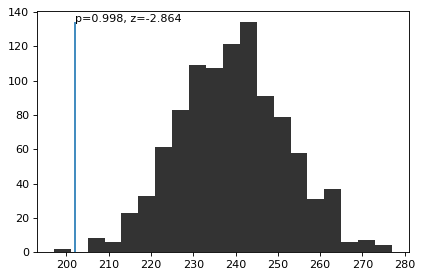

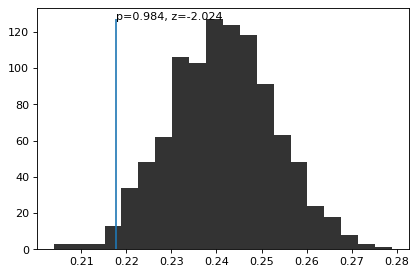

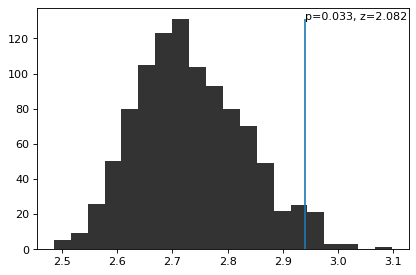

In [117]:
PlotPermutationP(Permuted_Sib_conn, Sib_Conn)
PlotPermutationP(Permuted_Sib_cohe, Sib_Cohe)
PlotPermutationP(Permuted_Sib_short_path, Sib_Short)

In [96]:
for topN in range(100, 10, -10):
    Permuted_Sib_cohe = []
    Permuted_Sib_conn = []
    for i in range(1000):
        adj_mat_ = pd.read_csv("dat/permut_connectome/{}.csv".format(i), index_col=0)
        g_ = LoadConnectome2(adj_mat_)
        x,y = ScoreSTRSet(g_, Sib_Bias_avgz.head(topN).index.values, EdgeWeightsDict)
        Permuted_Sib_cohe.append(x)
        Permuted_Sib_conn.append(y)
    XXX2, YYY2 = ScoreSTRSet(g, Sib_Bias_avgz.head(topN).index.values, EdgeWeightsDict)
    Z, P = GetPermutationP(Permuted_Sib_cohe, XXX2)
    Z2, P2 = GetPermutationP(Permuted_Sib_conn, YYY2)
    print(topN, Z, P, Z2, P2)

100 -4.41997384332808 1.0 -6.683131961868606 1.0
90 -3.9395077156611986 1.0 -6.2872927132769245 1.0
80 -0.8523839108380483 0.8021978021978022 -2.6910672582341073 0.996003996003996
70 -1.9609870271255057 0.977022977022977 -2.563538066615537 0.994005994005994
60 -2.57069696247154 0.997002997002997 -2.8306182554774426 0.998001998001998
50 -2.0239458270544297 0.984015984015984 -2.86410369820343 0.998001998001998
40 -2.055087420982334 0.978021978021978 -2.524948962558976 0.993006993006993
30 -0.9243582105032474 0.8251748251748252 -0.7795649793199567 0.7642357642357642
20 -2.156824418139822 0.985014985014985 -2.8001953407175186 0.999000999000999


In [322]:
#### Connectivity

In [589]:
ASD_Conn_perm, ASD_Cohe_perm = [], []
Sib_Conn_perm, Sib_Cohe_perm = [], []
for i in range(1,500,1):
    adj_mat_ = pd.read_csv("dat/perm-maintain_region/con-{}.csv".format(i), index_col=0)
    g_ = LoadConnectome2(adj_mat_)
    x,y = ScoreSTRSet(g_, SparkMetaBias.head(50).index.values, EdgeWeightsDict)
    ASD_Conn_perm.append(y)
    ASD_Cohe_perm.append(x)
    x,y = ScoreSTRSet(g_, Sib_Bias_avgz.head(50).index.values, EdgeWeightsDict)
    Sib_Conn_perm.append(y)
    Sib_Cohe_perm.append(x)
ASD_Cohe, ASD_Conn = ScoreSTRSet(g, SparkMetaBias.head(50).index.values, EdgeWeightsDict)
Sib_Cohe, Sib_Conn = ScoreSTRSet(g, Sib_Bias_avgz.head(50).index.values, EdgeWeightsDict)

In [590]:
np.var(ASD_Conn_perm)

35.8084907289529

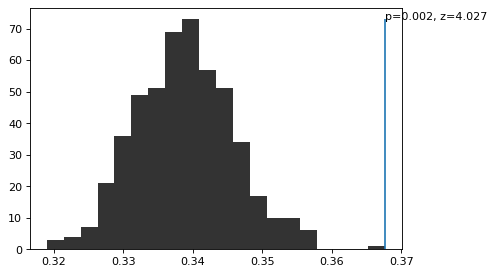

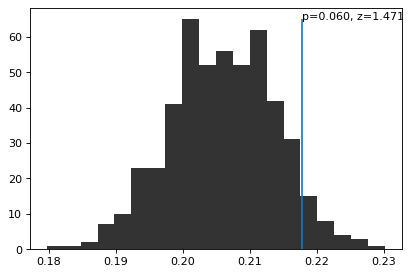

In [332]:
PlotPermutationP(ASD_Cohe_perm, ASD_Cohe)
PlotPermutationP(Sib_Cohe_perm, Sib_Cohe)

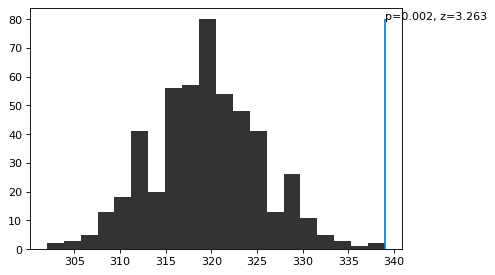

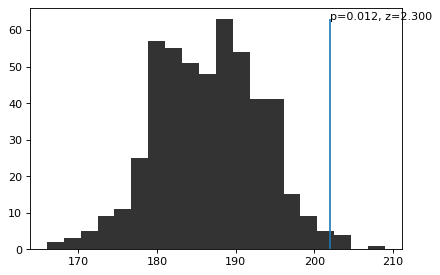

In [333]:
PlotPermutationP(ASD_Conn_perm, ASD_Conn)
PlotPermutationP(Sib_Conn_perm, Sib_Conn)

In [334]:
Permuted_ASD_short_path
Permuted_Sib_short_path = []
for i in range(1,500,1):
    adj_mat_ = pd.read_csv("dat/perm-maintain_region/con-{}.csv".format(i), index_col=0)
    g_ = LoadConnectome2(adj_mat_)
    _subgraph = subgraph(g_, SparkMetaBias.head(50).index.values)
    avg_path = _subgraph.average_path_length()
    Permuted_ASD_short_path.append(avg_path)
    
    _subgraph = subgraph(g_, Sib_Bias_avgz.head(50).index.values)
    avg_path = _subgraph.average_path_length()
    Permuted_Sib_short_path.append(avg_path)
    
_subgraph = subgraph(g, SparkMetaBias.head(50).index.values)
avg_path = _subgraph.average_path_length()
ASD_short_path = avg_path

_subgraph = subgraph(g, Sib_Bias_avgz.head(50).index.values)
avg_path = _subgraph.average_path_length()
Sib_short_path = avg_path

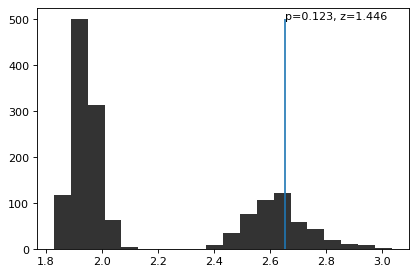

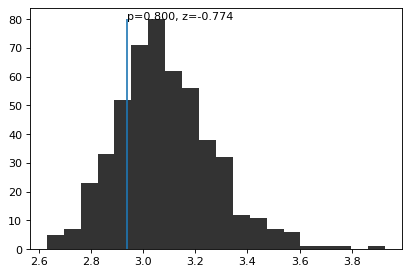

In [335]:
PlotPermutationP(Permuted_ASD_short_path, ASD_short_path)
PlotPermutationP(Permuted_Sib_short_path, Sib_short_path)

In [337]:
DF = SparkMetaBias
top_nodes = g.vs.select(label_in=DF.head(50).index.values)
g_sub_ = g.subgraph(top_nodes)

In [352]:
XX = []
YY1 = []
YY2 = []
for label in DF.head(50).index.values:
    g_node = g.vs.select(label_eq=label)
    g_cir_node = g_sub_.vs.select(label_eq=label)
    #rint(g_node.degree()[0]/g_cir_node.degree()[0])
    XX.append(g_cir_node.degree()[0]/g_node.degree()[0])
    YY1.append(g_cir_node.degree()[0])
    YY2.append(g_node.degree()[0])

(0.36674151407374067, 0.008802389835712755)
(-0.25809234831853056, 0.07035401620935153)


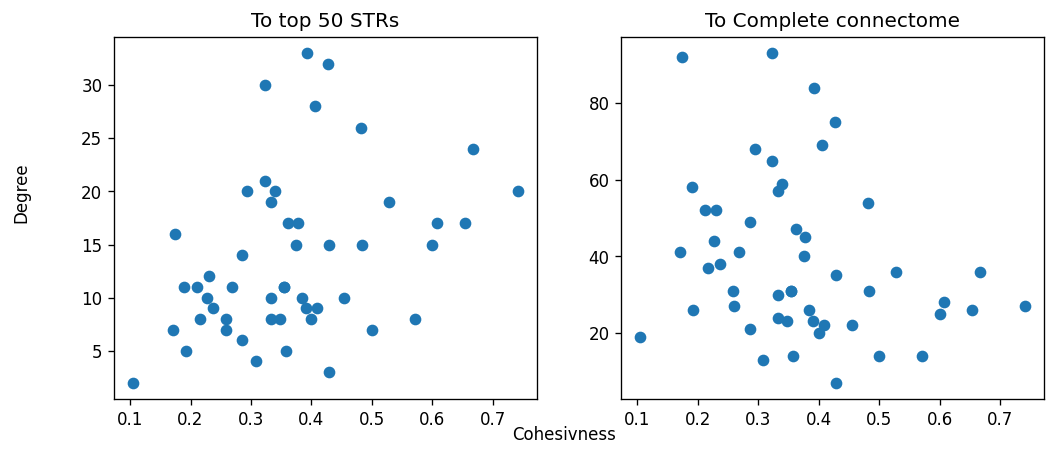

In [361]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), dpi=120)
ax1.scatter(XX, YY1)
ax2.scatter(XX, YY2)
ax1.set_title("To top 50 STRs")
ax2.set_title("To Complete connectome")
fig.text(0.5, 0.04, 'Cohesivness', ha='center')
fig.text(0.04, 0.5, 'Degree', rotation=90)
print(pearsonr(XX, YY1))
print(pearsonr(XX, YY2))

In [375]:
idx=5
adj_mat_ = pd.read_csv("dat/perm-maintain_region/con-{}.csv".format(idx), index_col=0)
g2 = LoadConnectome2(adj_mat_)
top_nodes2 = g2.vs.select(label_in=DF.head(50).index.values)
g_sub_2 = g2.subgraph(top_nodes)

In [376]:
XX_ = []
YY1_ = []
YY2_ = []
for label in DF.head(50).index.values:
    g_node = g2.vs.select(label_eq=label)
    g_cir_node = g_sub_2.vs.select(label_eq=label)
    #rint(g_node.degree()[0]/g_cir_node.degree()[0])
    XX_.append(g_cir_node.degree()[0]/g_node.degree()[0])
    YY1_.append(g_cir_node.degree()[0])
    YY2_.append(g_node.degree()[0])

In [434]:
color_dict = dict(zip(["Olfactory_areas", "Striatum", "Thalamus", "Isocortex", "Hippocampal_region", 
                       "Hippocampal_formation", "Cortical_subplate", "Midbrain", "Pallidum"], 
                      ["cyan", "brown", "red", "blue", "green", "olive", "purple", "yellow", "pink"]))

In [435]:

for i in range(50):
    color_dict[str2reg[DF.head(50).index.values[i]]]

(0.35110774319000204, 0.012416899994997435)
(-0.1654951673411001, 0.2507331623153307)


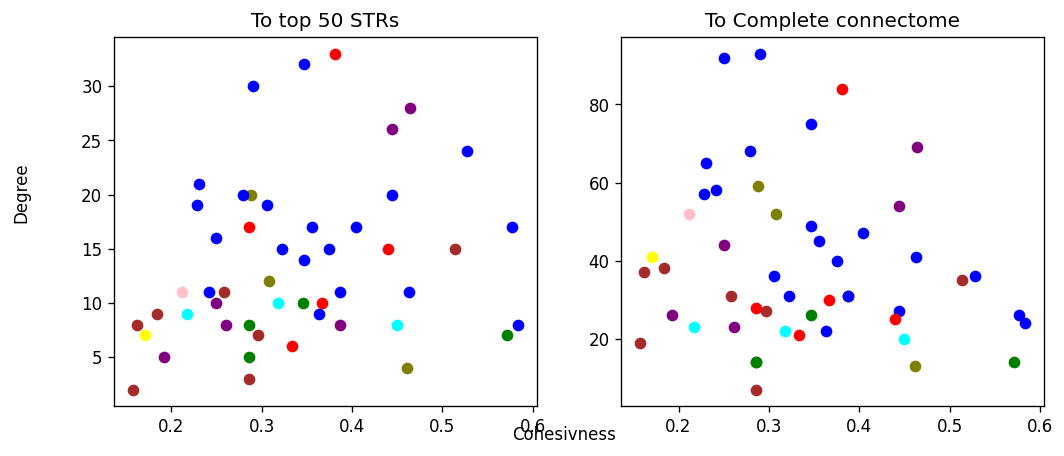

In [437]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), dpi=120)
#ax1.scatter(XX_, YY1_)
#ax2.scatter(XX_, YY2_)
for i in range(50):
    x = XX_[i]
    y1 = YY1[i]
    y2 = YY2[i]
    _color = color_dict[str2reg[DF.head(50).index.values[i]]]
    ax1.scatter(x, y1, color=_color)
    ax2.scatter(x, y2, color=_color)
ax1.set_title("To top 50 STRs")
ax2.set_title("To Complete connectome")
fig.text(0.5, 0.04, 'Cohesivness', ha='center')
fig.text(0.04, 0.5, 'Degree', rotation=90)
print(pearsonr(XX_, YY1_))
print(pearsonr(XX_, YY2_))

In [381]:
ASD_Cohe, ASD_Conn = [], []
for label in DF.head(50).index.values:
    g_node = g.vs.select(label_eq=label)
    g_cir_node = g_sub_.vs.select(label_eq=label)
    #print(label, g_cir_node.degree()[0])
    ASD_Cohe.append(g_cir_node.degree()[0]/g_node.degree()[0])
    ASD_Conn.append(g_cir_node.degree()[0])

In [386]:
ASD_Cohe_EachNode_Pertub, ASD_Conn_EachNode_Pertub = [], []
for i in range(2, 501, 1):
    tmp_ASD_Cohe, tmp_ASD_Conn = [], []
    adj_mat_ = pd.read_csv("dat/perm-maintain_region/con-{}.csv".format(i), index_col=0)
    g2 = LoadConnectome2(adj_mat_)
    top_nodes2 = g2.vs.select(label_in=DF.head(50).index.values)
    g_sub_2 = g2.subgraph(top_nodes)
    for label in DF.head(50).index.values:
        g_node = g2.vs.select(label_eq=label)
        g_cir_node = g_sub_2.vs.select(label_eq=label)
        tmp_ASD_Cohe.append(g_cir_node.degree()[0]/g_node.degree()[0])
        tmp_ASD_Conn.append(g_cir_node.degree()[0])
    ASD_Cohe_EachNode_Pertub.append(np.array(tmp_ASD_Cohe))
    ASD_Conn_EachNode_Pertub.append(np.array(tmp_ASD_Conn))
ASD_Cohe_EachNode_Pertub = np.array(ASD_Cohe_EachNode_Pertub)
ASD_Conn_EachNode_Pertub = np.array(ASD_Conn_EachNode_Pertub)

In [387]:
ASD_Cohe_EachNode_Pertub.shape

(499, 50)

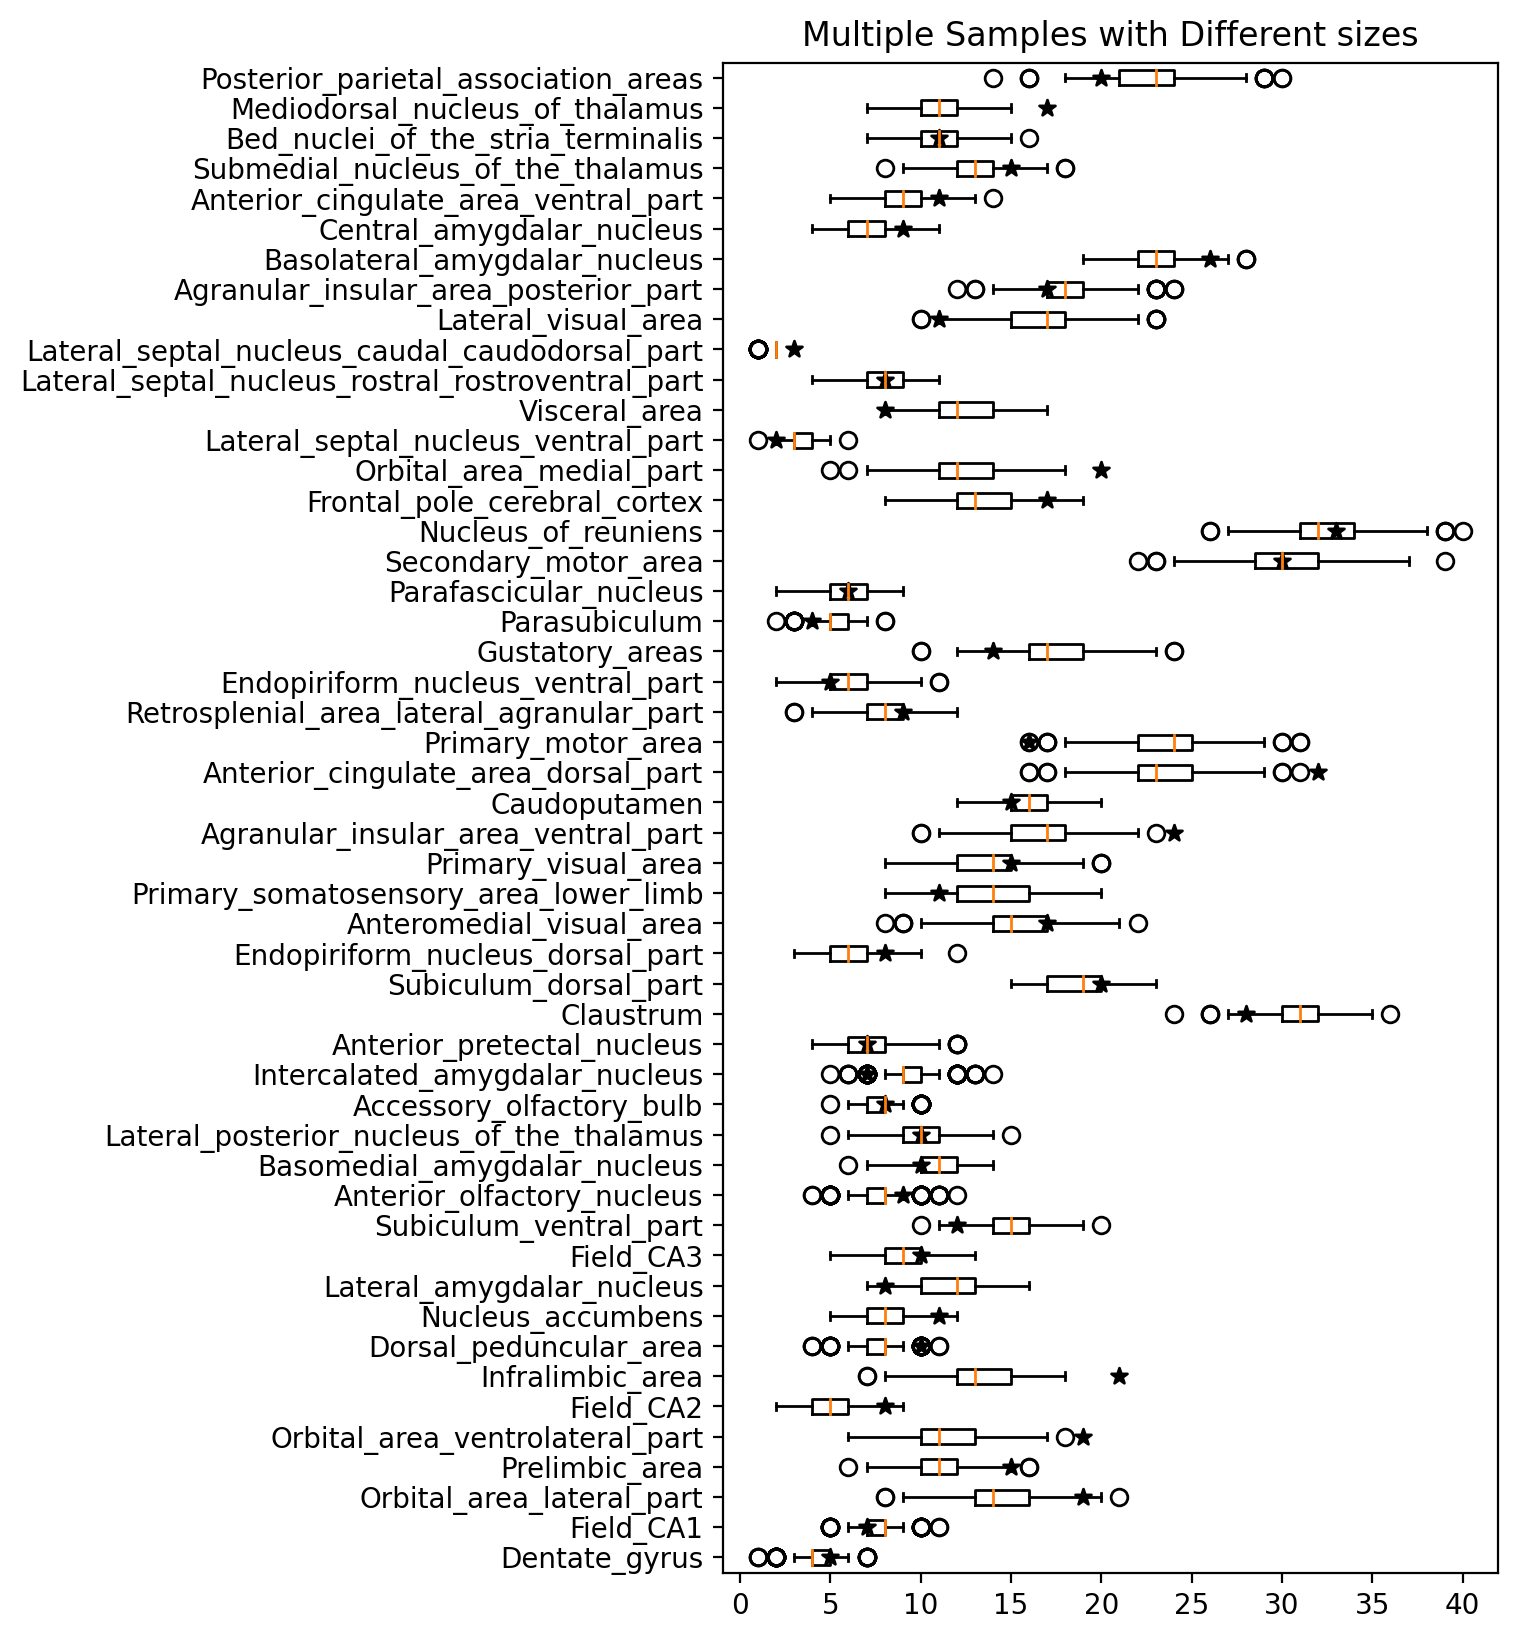

In [400]:
data = [ASD_Conn_EachNode_Pertub[:, x] for x in range(50)]
fig, ax = plt.subplots(dpi=200, figsize=(5,10))
ax.set_title('Multiple Samples with Different sizes')
ax.boxplot(data, vert=False)
for i in range(1, 51, 1):
    ax.scatter(ASD_Conn[i-1], i, color="black", marker="*")
plt.yticks(range(1, 51, 1), DF.head(50).index.values)
plt.show()

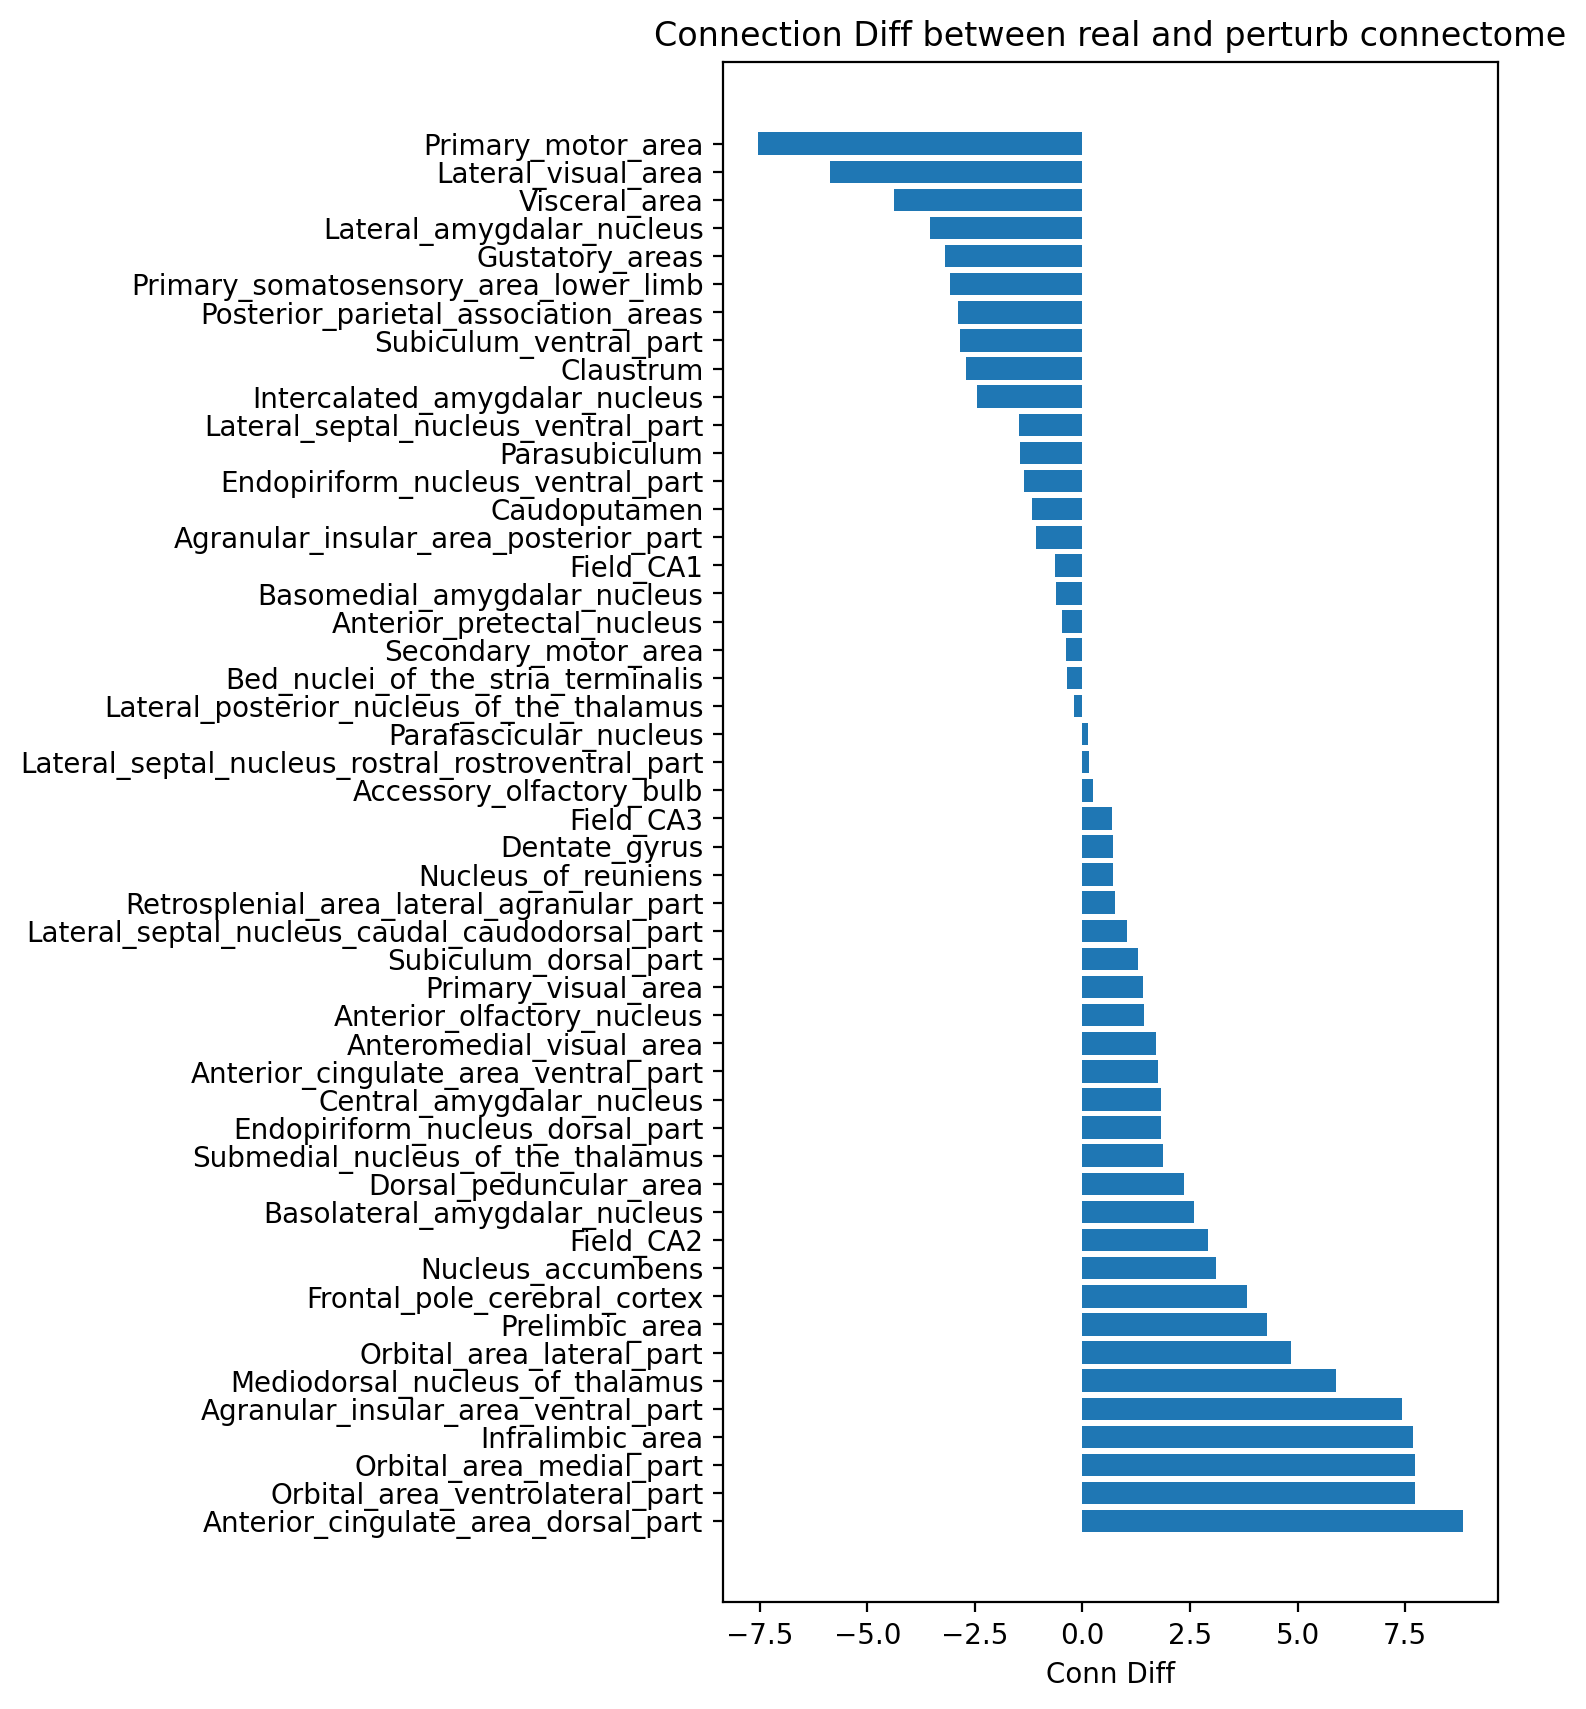

In [411]:
plt.rcdefaults()
fig, ax = plt.subplots(dpi=200, figsize=(5,10))

# Example data
people = DF.head(50).index.values
y_pos = np.arange(len(people))
performance = ASD_Conn - np.array([np.mean(ASD_Conn_EachNode_Pertub[:, x]) for x in range(50)])

sorted_name = [x for _,x in sorted(zip(performance,people))]
sorted_performance = sorted(performance)

ax.barh(y_pos, sorted_performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(sorted_name)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Conn Diff')
ax.set_title('Connection Diff between real and perturb connectome')

plt.show()

In [2]:
#graph = LoadConnectome2(ConnFil="../dat/allen-mouse-conn/jw-conn-al1.csv")
graph = LoadConnectome2(ConnFil="../dat/allen-mouse-conn/connectome-log.csv")

## Connectivity of simulated genes

#### 1. Exp Level 

In [3]:
ExpLevel = pd.read_csv("dat/bias/Agg.explevel.Mutcount.bias.csv", index_col="STR")
ExpLevel_Ecount, ExpLevel_cohe = GetConnectivity_Edge(graph, ExpLevel)
DIR = "/Users/jiayao/Work/ASD_Circuits/src/dat/bias/DNV_SM_ExpLevel/"
sim_ecounts = np.empty(0)
sim_cohes = np.empty(0)
for i in range(1000):
    tmp_df = pd.read_csv("{}/dnv_sm.{}.csv".format(DIR, i), index_col="STR")
    tmp_ecount, tmp_cohe = GetConnectivity_Edge(graph, tmp_df)
    sim_ecounts = np.append(sim_ecounts, tmp_ecount)
    sim_cohes = np.append(sim_cohes, tmp_cohe)

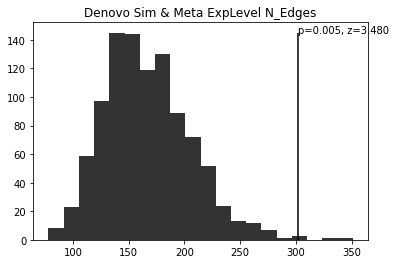

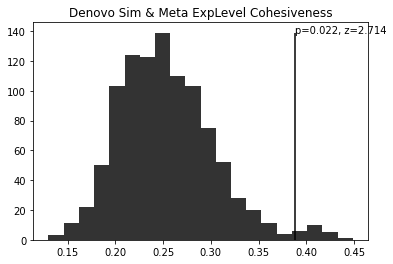

In [4]:
PlotPermutationP(sim_ecounts, ExpLevel_Ecount, title="Denovo Sim & Meta ExpLevel N_Edges")
PlotPermutationP(sim_cohes, ExpLevel_cohe, title="Denovo Sim & Meta ExpLevel Cohesiveness")

In [17]:
5.0 / 23

0.21739130434782608

#### 2. Specificity

In [5]:
AvgZ = pd.read_csv("dat/bias/Agg.avgZ.Mutcount.bias.csv", index_col="STR")
AvgZ_Ecount, AvgZ_cohe = GetConnectivity_Edge(graph, AvgZ)
DIR = "/Users/jiayao/Work/ASD_Circuits/src/dat/bias/DNV_SM_AvgZ/"
sim_ecounts = np.empty(0)
sim_cohes = np.empty(0)
for i in range(1000):
    tmp_df = pd.read_csv("{}/dnv_sm.{}.csv".format(DIR, i), index_col="STR")
    tmp_ecount, tmp_cohe = GetConnectivity_Edge(graph, tmp_df)
    sim_ecounts = np.append(sim_ecounts, tmp_ecount)
    sim_cohes = np.append(sim_cohes, tmp_cohe)

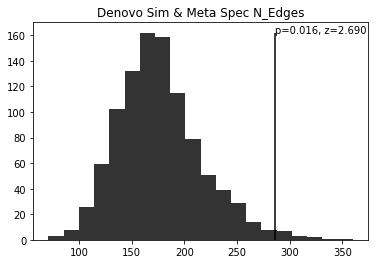

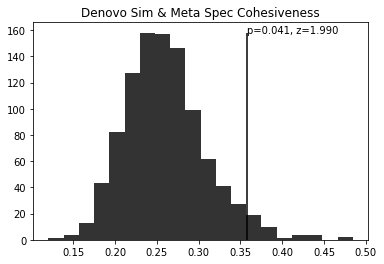

In [6]:
PlotPermutationP(sim_ecounts, AvgZ_Ecount, title="Denovo Sim & Meta Spec N_Edges")
PlotPermutationP(sim_cohes, AvgZ_cohe, title="Denovo Sim & Meta Spec Cohesiveness")

## Edge Permutation Test

#### 1. ExpLevel 

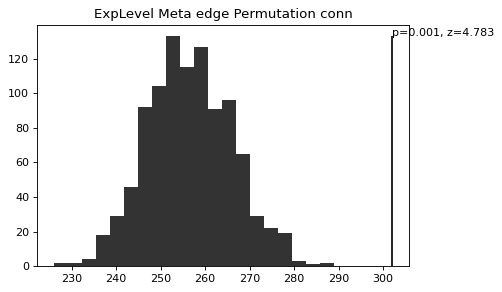

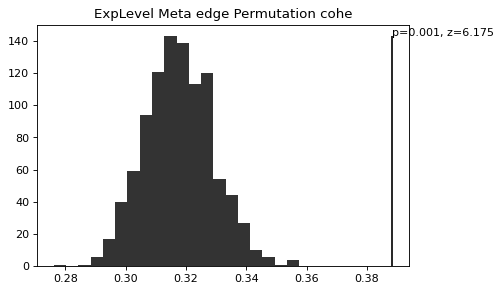

In [11]:
g2_ecounts, g2_cohes = EdgePermutation(graph, ExpLevel, Npermute=1000)  
PlotPermutationP(g2_ecounts, ExpLevel_Ecount, title="ExpLevel Meta edge Permutation conn")
PlotPermutationP(g2_cohes, ExpLevel_cohe, title="ExpLevel Meta edge Permutation cohe")

#### 2. Spec

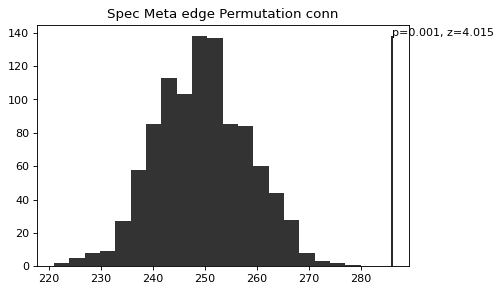

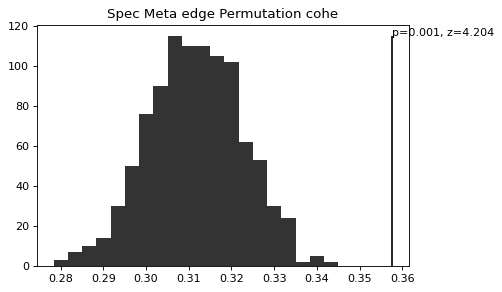

In [12]:
g2_ecounts, g2_cohes = EdgePermutation(graph, AvgZ, Npermute=1000)  
PlotPermutationP(g2_ecounts, AvgZ_Ecount, title="Spec Meta edge Permutation conn")
PlotPermutationP(g2_cohes, AvgZ_cohe, title="Spec Meta edge Permutation cohe")

## Node Permutation test

#### 1. ExpLevel

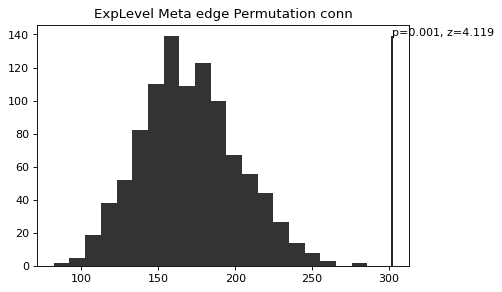

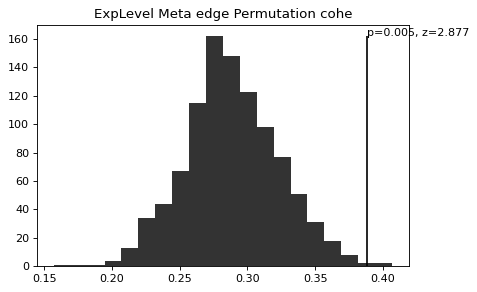

In [14]:
g2_ecounts, g2_cohes = NodePermutation(graph, ExpLevel, Npermute=1000)
PlotPermutationP(g2_ecounts, ExpLevel_Ecount, title="ExpLevel Meta edge Permutation conn")
PlotPermutationP(g2_cohes, ExpLevel_cohe, title="ExpLevel Meta edge Permutation cohe")

#### 2. Spec

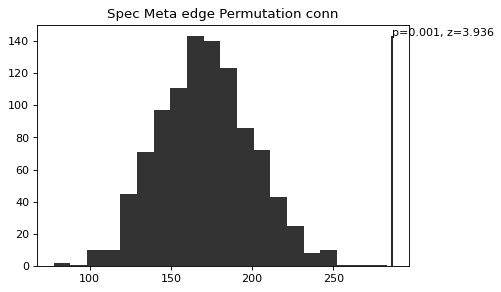

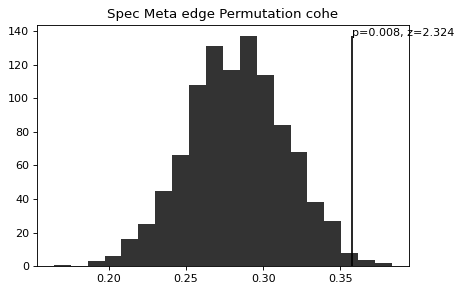

In [16]:
g2_ecounts, g2_cohes = NodePermutation(graph, AvgZ, Npermute=1000)  
PlotPermutationP(g2_ecounts, AvgZ_Ecount, title="Spec Meta edge Permutation conn")
PlotPermutationP(g2_cohes, AvgZ_cohe, title="Spec Meta edge Permutation cohe")

In [18]:
50/213

0.2347417840375587

### Bias vs Cohesiveness

In [ ]:
# asc
asc_zmatch_bias = pd.read_csv("dat/bias/Agg.AvgZ.Mutcount.bias.csv", index_col="STR")
Bias_vs_Cohesiveness(graph, asc_zmatch_bias, title="meta zmatch")
asc_elevel_bias = pd.read_csv("dat/bias/Agg.explevel.Mutcount.bias.csv", index_col="STR")
Bias_vs_Cohesiveness(graph, asc_elevel_bias, title="meta elevel")

In [ ]:
# spark
spark_zmatch_bias = pd.read_csv("dat/bias/asd.spark.zmatch.rank.csv", index_col="STR")
Bias_vs_Cohesiveness(graph, spark_zmatch_bias, title="spark zmatch")
spark_elevel_bias = pd.read_csv("dat/bias/spark.explevel.rank.tsv", index_col="STR")
Bias_vs_Cohesiveness(graph, spark_elevel_bias, title="spark elevel")

In [ ]:
# spark tada
spark_zmatch_bias = pd.read_csv("dat/bias/asd.sparktada.zmatch.rank.csv", index_col="STR")
Bias_vs_Cohesiveness(graph, spark_zmatch_bias, title="spark zmatch")
spark_elevel_bias = pd.read_csv("dat/bias/sparktada.explevel.rank.tsv", index_col="STR")
Bias_vs_Cohesiveness(graph, spark_elevel_bias, title="spark elevel")

In [ ]:
# tada
tada_zmatch_bias = pd.read_csv("dat/bias/asd.tada.zmatch.rank.csv", index_col="STR")
Bias_vs_Cohesiveness(graph, tada_zmatch_bias, title="tada zmatch")
tada_elevel_bias = pd.read_csv("dat/bias/tada.explevel.rank.tsv", index_col="STR")
Bias_vs_Cohesiveness(graph, tada_elevel_bias, title="tada elevel")

In [ ]:
# sibling
sib_zmatch_bias = pd.read_csv("dat/bias/asd.sib.zmatch.rank.csv", index_col="STR")
Bias_vs_Cohesiveness(graph, sib_zmatch_bias, title="sibling zmatch")
sib_elevel_bias = pd.read_csv("dat/bias/sib.explevel.rank.tsv", index_col="STR")
Bias_vs_Cohesiveness(graph, sib_elevel_bias, title="sibling elevel")

In [ ]:
SSC_struct_rank_fil = "dat/bias/Agg.AvgZ.Mutcount.bias.csv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)

In [ ]:
print(g.vcount(), g.ecount())
print(g2.vcount(), g2.ecount())

In [ ]:
edge_permute_stat = g2.ecount()
g2_ecounts = EdgePermutation(g, top_nodes, edge_permute_stat, Npermute=100)
PlotPermutationP(g2_ecounts, edge_permute_stat)

In [ ]:
#node_permute_stat = Cohesiveness(g, idx_top50nodes, TopN=1)
node_permute_stat = g2.ecount()
node_null = NodePermutation(g, top_nodes, node_permute_stat, Npermute=100)
PlotPermutationP(node_null, node_permute_stat)

In [ ]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Random")

In [ ]:
190 / 2450

In [ ]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Region")

In [ ]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Percent")

In [ ]:
190/1256

In [ ]:
SSC_struct_rank_fil = "dat/bias/asd.tada.zmatch.rank.csv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)

In [ ]:
edge_permute_stat = g2.ecount()
g2_ecounts = EdgePermutation(g, top_nodes, edge_permute_stat, Npermute=100)
PlotPermutationP(g2_ecounts, edge_permute_stat)

In [ ]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Random")

In [ ]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Region")

In [ ]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Percent")

In [ ]:
SSC_struct_rank_fil = "dat/bias/asd.spark.zmatch.rank.csv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)

In [ ]:
edge_permute_stat = g2.ecount()
g2_ecounts = EdgePermutation(g, top_nodes, edge_permute_stat, Npermute=100)
PlotPermutationP(g2_ecounts, edge_permute_stat)

In [ ]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Random")

In [ ]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Region")

In [ ]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Percent")

In [ ]:
194 / 1315

In [ ]:
STR2REG, REG2STR = LoadSTR2REG()

In [ ]:
for i, row in pd.read_csv(SSC_struct_rank_fil).iterrows():
    str_ = row["STR"]
    print(str_)
    

In [ ]:
jon_ssc_level = pd.read_csv("dat/bias/jon_bias/zscore-vs_match-ssc-1.csv")
jon_ssc_spec = pd.read_csv("dat/bias/jon_bias/zscore-vs_match-ssc-2.csv")
jon_spark_level = pd.read_csv("dat/bias/jon_bias/zscore-vs_match-spark-1.csv")
jon_spark_spec = pd.read_csv("dat/bias/jon_bias/zscore-vs_match-spark-2.csv")
jon_tada_level = pd.read_csv("dat/bias/jon_bias/zscore-vs_match-tada-1.csv")
jon_tada_spec = pd.read_csv("dat/bias/jon_bias/zscore-vs_match-tada-2.csv")

In [ ]:
g, top_structs = LoadConnectome(jon_ssc_level, Bin=True)
ssc_level_top_nodes = g.vs.select(label_in=top_structs)
g_ssc_level = g.subgraph(ssc_level_top_nodes)

In [ ]:
edge_permute_stat = g_ssc_level.ecount()
print(edge_permute_stat)
g_ssc_level_ecounts = EdgePermutation(g, top_nodes, edge_permute_stat, Npermute=100)
PlotPermutationP(g_ssc_level_ecounts, edge_permute_stat)

In [ ]:
x, n, r, p = NodePermutationBinom(g, 50, g_ssc_level, Npermute=100, mode="Random")
print("Random %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))
x, n, r, p = NodePermutationBinom(g, 50, g_ssc_level, Npermute=100, mode="Random")
print("Region %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))
x, n, r, p = NodePermutationBinom(g, 50, g_ssc_level, Npermute=100, mode="Percent")
print("Percent %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))

In [ ]:
g, top_structs = LoadConnectome(jon_spark_level, Bin=True)
spark_level_top_nodes = g.vs.select(label_in=top_structs)
g_spark_level = g.subgraph(spark_level_top_nodes)

In [ ]:
edge_permute_stat = g_spark_level.ecount()
print(edge_permute_stat)
g_spark_level_ecounts = EdgePermutation(g, top_nodes, edge_permute_stat, Npermute=100)
PlotPermutationP(g_spark_level_ecounts, edge_permute_stat)

In [ ]:
x, n, r, p = NodePermutationBinom(g, 50, g_spark_level, Npermute=100, mode="Random")
print("Random %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))
x, n, r, p = NodePermutationBinom(g, 50, g_spark_level, Npermute=100, mode="Random")
print("Region %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))
x, n, r, p = NodePermutationBinom(g, 50, g_spark_level, Npermute=100, mode="Percent")
print("Percent %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))

In [ ]:
len(set(jon_ssc_level.head(50)["STRUC"].values).intersection(jon_spark_level.head(50)["STRUC"].values))

In [ ]:
def run_connectivity_tests(str_rank, ):
    g, top_structs = LoadConnectome(str_rank, Bin=True)
    top_nodes = g.vs.select(label_in=top_structs)
    g2 = g.subgraph(top_nodes)

    print("Edge Permutation Test")
    edge_permute_stat = g2.ecount()
    print("N edges:", edge_permute_stat)
    g2_ecounts = EdgePermutation(g, top_nodes, edge_permute_stat, Npermute=100)
    PlotPermutationP(g2_ecounts, edge_permute_stat)
    
    print("Node Permutation Test")
    x, n, r, p = NodePermutationBinom(g, 50, g2, Npermute=100, mode="Random")
    print("Random %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))
    x, n, r, p = NodePermutationBinom(g, 50, g2, Npermute=100, mode="Random")
    print("Region %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))
    x, n, r, p = NodePermutationBinom(g, 50, g2, Npermute=100, mode="Percent")
    print("Percent %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))

In [ ]:
run_connectivity_tests(jon_ssc_level)

In [ ]:
jw_ssc_level = pd.read_csv("dat/bias/ssc.explevel.rank.tsv")
jw_spark_level = pd.read_csv("dat/bias/spark.explevel.rank.tsv")
jw_tada_level = pd.read_csv("dat/bias/tada.explevel.rank.tsv")

In [ ]:
run_connectivity_tests(jw_ssc_level)

In [ ]:
run_connectivity_tests(jw_spark_level)

In [ ]:
len(set(jon_ssc_level.head(50)["STRUC"].values).intersection(jw_ssc_level.head(50)["STR"].values))

In [ ]:
#top_nodes = g.vs.select(label_in=top_structs)
#g2 = g.subgraph(top_nodes)
g_jon_ssc_level = g.subgraph(g.vs.select(label_in=jon_ssc_level.head(50)["STRUC"].values))
g_jon_spark_level = g.subgraph(g.vs.select(label_in=jon_spark_level.head(50)["STRUC"].values))
g_jon_tada_level = g.subgraph(g.vs.select(label_in=jon_tada_level.head(50)["STRUC"].values))
g_jw_ssc_level = g.subgraph(g.vs.select(label_in=jw_ssc_level.head(50)["STR"].values))
g_jw_spark_level = g.subgraph(g.vs.select(label_in=jw_spark_level.head(50)["STR"].values))
g_jw_tada_level = g.subgraph(g.vs.select(label_in=jw_tada_level.head(50)["STR"].values))

In [ ]:
for i, (name, gg) in enumerate(zip(["g_jon_ssc_level", "g_jon_spark_level", "g_jon_tada_level", 
                                 "g_jw_ssc_level", "g_jw_spark_level", "g_jw_tada_level"], 
                                [g_jon_ssc_level, g_jon_spark_level, g_jon_tada_level, 
                                 g_jw_ssc_level, g_jw_spark_level, g_jw_tada_level])):
    plt.hist(gg.degree())
    plt.title(name)
    plt.show()

In [ ]:
plt.hist(g_jon_ssc_level.degree())

In [ ]:
for v in g_jw_ssc_level.vs:
    print(v["label"], v.degree())

In [ ]:
g_jw_ssc_level.vs.find(label="Anterior_cingulate_area_dorsal_part").degree()

In [ ]:
g.vs.find(label="Anterior_cingulate_area_dorsal_part").degree()

In [ ]:
print(27/66, 50/213)

In [ ]:
def MakeConsensus(gs, g, names, topN=50):
    all_strs, all_str_names = [], []
    for g_ in gs:
        for v in g_.vs:
            all_strs.append(v['label'])
    all_strs = list(set(list(all_strs)))
    dat = []
    for str_ in all_strs:
        row = []
        for g_ in gs:
            try:
                row.append(g_.vs.find(label=str_).degree())
            except:
                row.append(0)
        dat.append(row)
    df = pd.DataFrame(data=dat, columns = names, index=all_strs)
    return df

In [ ]:
gs = [g_jon_ssc_level, g_jon_spark_level, g_jon_tada_level, g_jw_ssc_level, g_jw_spark_level, g_jw_tada_level]
names = ["g_jon_ssc_level", "g_jon_spark_level", "g_jon_tada_level", "g_jw_ssc_level", "g_jw_spark_level", "g_jw_tada_level"]
df = MakeConsensus(gs, g, names)
df.index.name = "STRUCT"
df.to_csv("dat/degrees.csv")

In [ ]:
df

In [ ]:
g_jon_ssc_level.is_directed()